<a href="https://colab.research.google.com/github/JungOhLee/LiTS_example/blob/main/BoneMeta_3D_v1.1_All128_DropRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install monai
!pip install nibabel
!pip install SimpleITK
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 17.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
LEVELS = 5
FILTER_NUM = 24

TRAINING_NAME = f'3D_Unet_DropRes_lv{LEVELS}_All128'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 128

# BATCH_SIZE = 120
BATCH_SIZE = 2
EPOCHS = 200

BASE_DIR = '/gdrive/MyDrive/LiTS_sample'
IMG_FOLDER_NAME = 'image_128'
LABEL_FOLDER_NAME = 'mask_128'

In [2]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [3]:
!git clone https://github.com/JungOhLee/LiTS_example.git ./git_clone
!mv  -v ./git_clone/* .

fatal: destination path './git_clone' already exists and is not an empty directory.
mv: cannot stat './git_clone/*': No such file or directory


In [4]:
!ls .

augmentation.py			       PrepareDataset.ipynb
BoneMeta_3D_v1.1_All128_DropRes.ipynb  __pycache__
downloader.py			       pytorch3dunet
git_clone			       README.md
model.py			       ResampleImages.ipynb
ModelTraining.ipynb		       sample_data
ModelTrainingWithMockdata.ipynb        UpsampleImages.ipynb
NpyToNifti.ipynb		       util


In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/gdrive/MyDrive/LiTS_sample/image_128 51
/gdrive/MyDrive/LiTS_sample/mask_128 51


In [7]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [8]:
# # z축 작은 녀석들만 남기기 
# SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
# SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
# IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
# len(IMG_FILES)

In [9]:
TRAIN_FILES = [f"volume-{i}.npy" for i in range(45)]
VAL_FILES = [f"volume-{i}.npy" for i in range(45,51)]
TEST_FILES = []

In [10]:
TRAIN_FILES = list(set(TRAIN_FILES) - set(VAL_FILES) - set(TEST_FILES))
VAL_FILES = list(set(VAL_FILES))
TEST_FILES = list(set(TEST_FILES))

In [11]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 45
val: 6
test: 0
total: 51



In [12]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

# Set dataloader

In [13]:
import torch 
import numpy as np
import time
import os, glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform


class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400)]

    def get_data_info(self):
        all_data_info = pd.read_csv(f'{BASE_DIR}/data_info_V_2022_04_20.csv')
        case_tuple = tuple([file_to_case(file) for file in self.case_files])
        include_idx = all_data_info.Case.str.startswith(case_tuple)
        return all_data_info.loc[include_idx]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        return self.get_case(idx)
    
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [14]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [15]:
# len(train_dataset)

In [16]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [17]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [18]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = ValDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 0.6043708919996789s
train: 45
val: 6



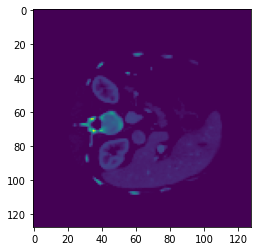

In [19]:
import matplotlib.pyplot as plt

sample_train = train_dataset[9]
plt.imshow(sample_train[0][1][PATCH_SIZE//2])

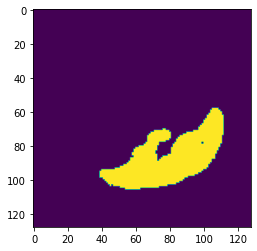

In [20]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

# Dataloader 

In [21]:
import multiprocessing
multiprocessing.cpu_count()

2

In [23]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = multiprocessing.cpu_count()

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [24]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [25]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [26]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [37]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import ResidualUNet3D, DropResidualUNet3D

def initModel():    
    segmentation_model = DropResidualUNet3D(in_channels=2, out_channels=2, num_groups=FILTER_NUM, f_maps=FILTER_NUM, final_sigmoid=True, testing=True, num_levels=LEVELS)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0005, weight_decay=0.0001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

2023-02-04 05:49:28,685 INFO     pid:15041 3DUnet:011:initModel Using CUDA; 1 devices.


In [38]:
segmentation_model

DropResidualUNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DropResNetBlock(
        (conv1): SingleConv(
          (groupnorm): GroupNorm(1, 2, eps=1e-05, affine=True)
          (conv): Conv3d(2, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (conv2): SingleConv(
          (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
          (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (conv3): SingleConv(
          (groupnorm): GroupNorm(24, 24, eps=1e-05, affine=True)
          (conv): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (dropout): Dropout(p=0.5, inplace=False)
        (non_linearity): ReLU(inplace=True)
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1,

In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

19867470

In [40]:
from util.util import enumerateWithEstimate
from monai.losses import DiceLoss

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLossVal(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True).unsqueeze(1)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
#     prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    prediction_g = prediction_g_multi_ch
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    ceLoss = nn.CrossEntropyLoss()
    ceLoss_g = ceLoss(prediction_g, label_g.squeeze(1).long())
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3,4])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3,4])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3,4])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + ceLoss_g + fnLoss_g.mean() * FN_LOSS 

def computeBatchLossVal(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True).unsqueeze(1)

    prediction_g_multi_ch = segmentation_model(input_g)
#     prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    prediction_g = prediction_g_multi_ch
    diceLoss_g = diceLoss(prediction_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3,4])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3,4])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3,4])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean()

diceLoss = DiceLoss(to_onehot_y=True, include_background=False)

In [41]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [42]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [43]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [44]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 10

totalTrainingSamples_count = 0 

2023-02-04 05:49:32,574 INFO     pid:15041 3DUnet:001:<module> Starting traning...


In [ ]:
for epoch_ndx in range(1, EPOCHS+1):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)
        
trn_writer.close()
val_writer.close()

2023-02-04 05:49:33,240 INFO     pid:15041 3DUnet:002:<module> Epoch 1 of 200, 23/3 batches of size 2*1
2023-02-04 05:49:33,246 WARNING  pid:15041 util.util:219:enumerateWithEstimate E1 Training ----/23, starting
2023-02-04 05:49:56,276 INFO     pid:15041 util.util:236:enumerateWithEstimate E1 Training    4/23, done at 2023-02-04 05:50:49, 0:01:01
2023-02-04 05:50:08,173 INFO     pid:15041 util.util:236:enumerateWithEstimate E1 Training    8/23, done at 2023-02-04 05:50:49, 0:01:02
2023-02-04 05:50:32,232 INFO     pid:15041 util.util:236:enumerateWithEstimate E1 Training   16/23, done at 2023-02-04 05:50:50, 0:01:02
2023-02-04 05:50:49,115 WARNING  pid:15041 util.util:249:enumerateWithEstimate E1 Training ----/23, done at 2023-02-04 05:50:49
2023-02-04 05:50:49,118 INFO     pid:15041 3DUnet:004:logMetrics E1 Unet bonemeta_fn_0_3D_Unet_DropRes_lv5_All128
2023-02-04 05:50:49,121 INFO     pid:15041 3DUnet:035:logMetrics E1 trn      0.7710 loss, 0.0508 precision, 0.6482 recall, 0.0941 f1 s

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /gdrive/MyDrive/LiTS_sample/logs

bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_trn_seg_2022-08-02_01.36.14
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_3in3out_val_seg_2022-08-02_01.36.14
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_01.38.21
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_03.39.03
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-05-04_07.15.44
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_trn_seg_2022-09-04_16.43.26
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_01.38.21
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_03.39.03
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-05-04_07.15.44
bonemeta_fn_0_3D_Unet_DropRes_lv6_All128_val_seg_2022-09-04_16.43.26
bonemeta_fn_0_3D_Unet_Res_lv5_All128_trn_seg_2022-04-21_15.19.04
bonemeta_fn_0_3D_Unet_Res_lv5_All128_val_seg_2022-04-21_15.19.04
bonemeta_fn_0_3D_Unet_Res_lv6_All128_trn_seg_2022-04-28_21.47.09
bonemeta_fn_0_3D_Unet_Res_lv6_All128_trn_seg_2022-04-29_08.34.58
bonemeta_fn_0_3D_Unet_Res_lv6_All1